<a href="https://colab.research.google.com/github/sharon44-ham/simpsons_cnn_classifier/blob/main/Copy_of_simpsons1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
alexattia_the_simpsons_characters_dataset_path = kagglehub.dataset_download('alexattia/the-simpsons-characters-dataset')

print('Data source import complete.')


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_1253.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_1236.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0649.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0892.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0245.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0449.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0223.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0206.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_1277.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/lisa_simpson/pic_0286.jpg
/kaggle/input/the-simpsons-characters-dataset/simpsons_data

In [ ]:
import os

char_path = '/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

char_dict = {}

# Loop through items in the main dataset folder
for item in os.listdir(char_path):
    item_path = os.path.join(char_path, item)

    # Check if it is a directory (i.e., a character folder)
    if os.path.isdir(item_path):
        char_dict[item] = len(os.listdir(item_path))  # Count number of images

# Show a few entries to verify
for char, count in list(char_dict.items())[:5]:
    print(f"{char}: {count} images")

print(f"\nTotal character folders found: {len(char_dict)}")


rainier_wolfcastle: 45 images
maggie_simpson: 128 images
krusty_the_clown: 1206 images
waylon_smithers: 181 images
professor_john_frink: 65 images

Total character folders found: 43


In [ ]:
# Sort character dictionary in descending order (most images first)
sorted_char_dict = dict(sorted(char_dict.items(), key=lambda item: item[1], reverse=True))

# View top 10 characters
top_chars = list(sorted_char_dict.keys())[:10]
print("Top 10 characters:", top_chars)


Top 10 characters: ['homer_simpson', 'ned_flanders', 'moe_szyslak', 'lisa_simpson', 'bart_simpson', 'marge_simpson', 'krusty_the_clown', 'principal_skinner', 'charles_montgomery_burns', 'milhouse_van_houten']


In [ ]:
import cv2
import numpy as np

data = []
IMG_SIZE = (80, 80)  # You can change size based on model or memory
channels = 1  # Use 1 for grayscale, 3 for RGB

for char in top_chars:
    path = os.path.join(char_path, char)
    for img_file in os.listdir(path):
        try:
            img_path = os.path.join(path, img_file)

            # Read image in grayscale
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) if channels == 1 else cv2.imread(img_path)

            # Resize image
            img = cv2.resize(img, IMG_SIZE)

            data.append([img, char])
        except Exception as e:
            # Skip corrupted or unreadable files
            continue

print(f"Total images loaded: {len(data)}")


Total images loaded: 13811


In [ ]:
import random
random.shuffle(data)

X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], channels)


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Sample labels (encoded):", y_encoded[:10])
print("Classes:", le.classes_)


Sample labels (encoded): [7 7 4 5 5 4 4 5 7 2]
Classes: ['bart_simpson' 'charles_montgomery_burns' 'homer_simpson'
 'krusty_the_clown' 'lisa_simpson' 'marge_simpson' 'milhouse_van_houten'
 'moe_szyslak' 'ned_flanders' 'principal_skinner']


In [ ]:
X = X / 255.0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Training samples:", X_train.shape[0])
print("Validation samples:", X_val.shape[0])


Training samples: 11048
Validation samples: 2763


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(80, 80, 1)),  # 1 for grayscale
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here

# ... (your existing code for data loading and preprocessing) ...

# Assuming 'y' is your list of labels
le = LabelEncoder()  # Define or re-initialize LabelEncoder here
y_encoded = le.fit_transform(y)

# ... (rest of your code) ...

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(80, 80, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


Epoch 1/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 56s 154ms/step - accuracy: 0.1716 - loss: 2.2558 - val_accuracy: 0.2555 - val_loss: 2.0511
Epoch 2/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 52s 149ms/step - accuracy: 0.2839 - loss: 1.9984 - val_accuracy: 0.3959 - val_loss: 1.7932
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 143ms/step - accuracy: 0.3986 - loss: 1.7384 - val_accuracy: 0.4738 - val_loss: 1.5827
Epoch 4/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 51s 149ms/step - accuracy: 0.4982 - loss: 1.4684 - val_accuracy: 0.5096 - val_loss: 1.4737
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 50s 146ms/step - accuracy: 0.5638 - loss: 1.2786 - val_accuracy: 0.5577 - val_loss: 1.3564
Epoch 6/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 83s 148ms/step - accuracy: 0.6330 - loss: 1.0709 - val_accuracy: 0.5639 - val_loss: 1.3462
Epoch 7/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 49s 141ms/step - accuracy: 0.6801 - loss: 0.9295 - val_accuracy: 0.5910 - val_loss: 1.3188
Epoch 8/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 53s 154ms/step - accuracy: 0.7263 - loss: 0

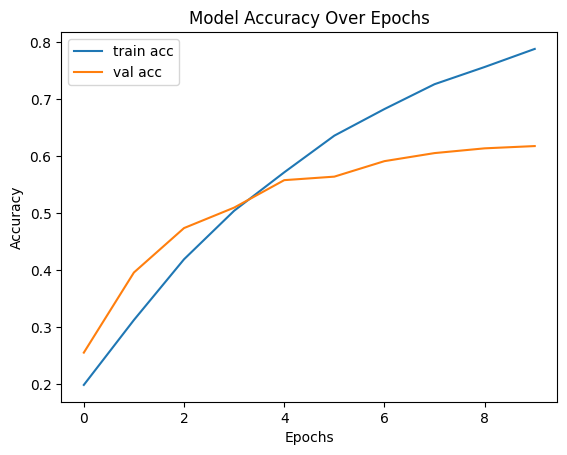

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.show()


In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')


87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6331 - loss: 1.3092
Validation Accuracy: 61.74%


In [ ]:
model.save('simpsons_character_model.h5')


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('simpsons_character_model.h5')


In [ ]:
# Predict on a new image
import cv2 as cv
import numpy as np

image_path = '/home/maryala-sharanya/Downloads/simp.jpeg'
img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

# Check if image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the path.")
else:
    img = cv.resize(img, (80, 80))  # Change 80 to (80, 80)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image

    # Get prediction
    prediction = model.predict(img)
    predicted_class = le.inverse_transform(np.argmax(prediction, axis=1))

    print(f'Predicted Class: {predicted_class[0]}')

Error: Could not load image from /home/maryala-sharanya/Downloads/simp.jpeg. Please check the path.


[ WARN:0@1718.159] global loadsave.cpp:268 findDecoder imread_('/home/maryala-sharanya/Downloads/simp.jpeg'): can't open/read file: check file path/integrity


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving simp.jpg to simp.jpg


In [ ]:
import os
os.listdir()


['simp.jpg', 'simpsons_character_model.h5', '.virtual_documents']

In [ ]:
image_path = 'simp.jpg'


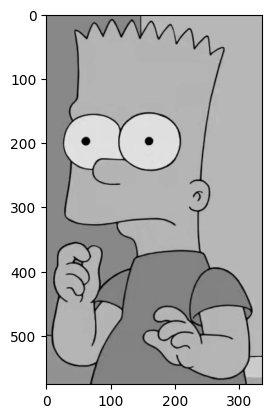

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
if img is None:
    print("Failed to load image")
else:
    plt.imshow(img, cmap='gray')
    plt.show()


In [ ]:
# Predict on a new image
import cv2 as cv
import numpy as np

image_path = 'simp.jpg'
img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

# Check if image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the path.")
else:
    img = cv.resize(img, (80, 80))  # Change 80 to (80, 80)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image

    # Get prediction
    prediction = model.predict(img)
    predicted_class = le.inverse_transform(np.argmax(prediction, axis=1))

    print(f'Predicted Class: {predicted_class[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted Class: bart_simpson


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving The-Simpsons-Cast.jpg to The-Simpsons-Cast.jpg


In [ ]:
import os
os.listdir()


['The-Simpsons-Cast.jpg',
 'simp.jpg',
 'simpsons_character_model.h5',
 '.virtual_documents']

In [ ]:
image_path='The-Simpsons-Cast.jpg'

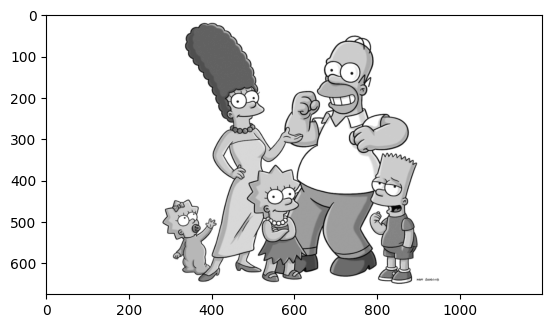

In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt

img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
if img is None:
    print("Failed to load image")
else:
    plt.imshow(img, cmap='gray')
    plt.show()


In [ ]:
# Predict on a new image
import cv2 as cv
import numpy as np

image_path = 'The-Simpsons-Cast.jpg'
img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

# Check if image was loaded successfully
if img is None:
    print(f"Error: Could not load image from {image_path}. Please check the path.")
else:
    img = cv.resize(img, (80, 80))  # Change 80 to (80, 80)
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize the image

    # Get prediction
    prediction = model.predict(img)
    predicted_class = le.inverse_transform(np.argmax(prediction, axis=1))

    print(f'Predicted Class: {predicted_class[0]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicted Class: lisa_simpson
